# SVM Tuning (Descriptors + Fingerprints)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem, RDLogger, DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, MACCSkeys
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors as md
from morfeus import XTB

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV,
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix,
)

from sklearn.svm import SVC
import shap
import optuna
from pyscf import gto, scf

/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Molecule, Descriptor + Fingerprints and Outlier Functions


In [3]:
def molecule_from_smiles(smiles):
    lg = RDLogger.logger()
    # Temporarily silence RDKit logs
    lg.setLevel(RDLogger.CRITICAL)
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"
    finally:
        # Re-enable logging afterward
        lg.setLevel(RDLogger.INFO)


def calculate_descriptors(molecule):
    # Get all descriptors (1D/2D)
    descriptor_names = []
    for descriptor, _ in Descriptors._descList:
        descriptor_names.append(descriptor)

    # Use descriptors to calculate values
    calculator = md.MolecularDescriptorCalculator(descriptor_names)
    descriptor_values = calculator.CalcDescriptors(molecule)

    # Create dictionary
    descriptors = dict(zip(descriptor_names, descriptor_values))
    return descriptors


def compute_iqr_limits(df, factor=1.5):
    # Calculate IQR limits
    limits = {}
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        # If IQR is 0 - column is too flat - skip
        if iqr == 0 or np.isnan(iqr):
            continue

        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        limits[col] = (lower, upper)
    return limits


def apply_iqr_limits(df, limits):
    # Apply the limits
    df_clipped = df.copy()
    for col, (lower, upper) in limits.items():
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped


def bitvect_to_dict(fp, prefix):
    # Convert bit vector to dictionary (create features)
    n_bits = fp.GetNumBits()
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    features = {}
    for i, v in enumerate(arr):
        features[f"{prefix}_{i}"] = int(v)
    return features


def calculate_fingerprints(mol):
    RDLogger.DisableLog("rdApp.*")
    # Calculate Morgan, RDKit, MACCS, AtomPair and Topological Torsion fingerprint
    feats = {}
    if mol is None:
        return feats

    # Morgan (ECFP) fingerprint
    morgan_bits = 2048
    morgan_radius = 2
    fp_morgan = rdMolDescriptors.GetMorganFingerprintAsBitVect(
        mol, radius=morgan_radius, nBits=morgan_bits
    )
    feats.update(bitvect_to_dict(fp_morgan, f"Morgan{morgan_radius}_{morgan_bits}"))

    # RDKit topological fingerprint
    rdk_bits = 2048
    fp_rdk = Chem.RDKFingerprint(mol, fpSize=rdk_bits)
    feats.update(bitvect_to_dict(fp_rdk, f"RDK_{rdk_bits}"))

    # MACCS keys (167 bits)
    fp_maccs = MACCSkeys.GenMACCSKeys(mol)
    feats.update(bitvect_to_dict(fp_maccs, "MACCS"))

    # AtomPair fingerprint
    ap_bits = 2048
    fp_ap = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=ap_bits)
    feats.update(bitvect_to_dict(fp_ap, f"AtomPair_{ap_bits}"))

    # Topological torsion fingerprint
    tt_bits = 2048
    fp_tt = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(
        mol, nBits=tt_bits
    )
    feats.update(bitvect_to_dict(fp_tt, f"Torsion_{tt_bits}"))

    RDLogger.EnableLog("rdApp.*")

    return feats


def prepare_3d_molecule(mol):
    # Create 3D molecule
    if mol is None:
        return None

    mol3d = Chem.AddHs(mol)

    try:
        # Calculate 3D coordinates and energy
        AllChem.EmbedMolecule(mol3d, AllChem.ETKDG())
        AllChem.UFFOptimizeMolecule(mol3d, maxIters=200)
    except Exception:
        return None

    return mol3d


def infer_charge_and_unpaired(mol):
    """
    Infer total charge and number of unpaired electrons from RDKit.
    Good enough for typical organic molecules.
    """
    total_charge = sum(a.GetFormalCharge() for a in mol.GetAtoms())
    n_unpaired = sum(a.GetNumRadicalElectrons() for a in mol.GetAtoms())
    return total_charge, n_unpaired


def compute_homo_lumo_xtb(mol):
    """
    Fast HOMO/LUMO computation using GFN2-xTB via morfeus.XTB.

    Returns the same keys as the old PySCF version:
        - HOMO_eV
        - LUMO_eV
        - HL_Gap_eV
    """
    feats = {
        "HOMO_eV": np.nan,
        "LUMO_eV": np.nan,
        "HL_Gap_eV": np.nan,
    }

    if mol is None:
        return feats

    # Create 3D molecule (reuses your existing pipeline)
    mol3d = prepare_3d_molecule(mol)
    if mol3d is None:
        return feats

    # Extract elements and coordinates
    conf = mol3d.GetConformer()
    elements = []
    coords = []
    for atom in mol3d.GetAtoms():
        pos = conf.GetAtomPosition(atom.GetIdx())
        elements.append(atom.GetSymbol())
        coords.append([pos.x, pos.y, pos.z])
    coords = np.array(coords, dtype=float)  # Å

    charge, n_unpaired = infer_charge_and_unpaired(mol3d)

    try:
        # method=2 -> GFN2-xTB
        xtb_calc = XTB(
            elements=elements,
            coordinates=coords,
            method=2,
            charge=charge,
            n_unpaired=n_unpaired,
        )

        feats["HOMO_eV"] = xtb_calc.get_homo(unit="eV")
        feats["LUMO_eV"] = xtb_calc.get_lumo(unit="eV")
        feats["HL_Gap_eV"] = xtb_calc.get_homo_lumo_gap(unit="eV")

    except Exception:
        # keep NaNs if xtb fails
        pass

    return feats

## Dataset Processing


In [5]:
# Configuration
ORIG_DATASET = "in_chemico_dataset.xlsx"
SKIP_ROWS = 1
SMILES_COL = "SMILES code"
TARGET_COL = "Phototoxicity"
FULL_OUTPUT_DATASET = "in_chemico_dataset_homolumo_processed.xlsx"

# Outputs
TRAIN_X_CSV = "in_chemico_homolumo_x_train.csv"
TEST_X_CSV = "in_chemico_homolumo_x_test.csv"
TRAIN_Y_CSV = "in_chemico_homolumo_y_train.csv"
TEST_Y_CSV = "in_chemico_homolumo_y_test.csv"

# Near constant threshold - tolerance
SIMILARITY_THRESHOLD = 0.7
# Correlation threshold
CORRELATION_THRESHOLD = 0.65

# Load dataset and skip first row (Header)
dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)

descriptor_rows = []
state_molecules = []
molecules = []

for smiles in dataset[SMILES_COL].astype(str):
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    if molecule is None:
        descriptor_rows.append({})
        continue

    # 1D/2D RDKit descriptors
    desc_feats = calculate_descriptors(molecule)

    # Fingerprints
    fp_feats = calculate_fingerprints(molecule)

    # HOMO / LUMO / gap from PySCF
    homo_lumo_feats = compute_homo_lumo_xtb(molecule)

    # Merge all feature dicts
    all_feats = {**desc_feats, **fp_feats, **homo_lumo_feats}
    descriptor_rows.append(all_feats)

# Convert list of dictionaries into dataframe
descriptor_data_all = pd.DataFrame(descriptor_rows)

# Keep everything + status
output = pd.concat(
    [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)], axis=1
)
output["MoleculeStatus"] = state_molecules

# Output whole dataset with descriptors and state
with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
    output.to_excel(writer, index=False, sheet_name="Descriptors")

print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
print(output.head().to_string(index=False))

# Drop failed molecules - boolean array
molecules_right = []
for molecule in molecules:
    if molecule is not None:
        molecules_right.append(True)
    else:
        molecules_right.append(False)
if not any(molecules_right):
    raise ValueError("No valid molecules after SMILES parsing.")

dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)

# Target
y_full = dataset_ok[TARGET_COL].astype(int)

# Take only numeric descriptor columns
X_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
for column in X_full.columns:
    X_full[column] = X_full[column].replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely NaN
all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
if all_nan_cols:
    print(f"Dropping {len(all_nan_cols)} NaN columns.")
    X_full = X_full.drop(columns=all_nan_cols)

# Split dataset - train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Calculate medians for each column in train only
train_medians = X_train.median(numeric_only=True)

# Fill missing values in both train and test using those medians
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

# Compute constants on train only
constant_cols = []
for col in X_train.columns:
    top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
    if top_freq >= SIMILARITY_THRESHOLD:
        constant_cols.append(col)

# Drop from train and apply same drop to test
if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)
    print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")

# Compute absolute correlation matrix on training data
corr_matrix = X_train.corr().abs()
# Keep only upper triangle of the matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find columns to drop - correlation
high_corr_cols = []
for col in upper.columns:
    if any(upper[col] > CORRELATION_THRESHOLD):
        high_corr_cols.append(col)

# Drop from both train and test
if high_corr_cols:
    X_train = X_train.drop(columns=high_corr_cols)
    X_test = X_test.drop(columns=high_corr_cols)
    print(f"Dropped {len(high_corr_cols)} highly correlated columns.")

# Compute IQR limits on training data
iqr_limits = compute_iqr_limits(X_train, factor=1.5)

# Apply limits to both train and test sets
X_train = apply_iqr_limits(X_train, iqr_limits)
X_test = apply_iqr_limits(X_test, iqr_limits)

# Scaling not necessary for all models
# Splitting the dataset to Fingerprint and Descriptor sets
FP_PREFIXES = (
    "Morgan",
    "RDK_",
    "MACCS",
    "AtomPair_",
    "Torsion_",
)  # Identify fingerprint columns by prefix
fp_cols = [c for c in X_train.columns if c.startswith(FP_PREFIXES)]
desc_cols = [c for c in X_train.columns if c not in fp_cols]

print(f"Descriptor columns: {len(desc_cols)}, fingerprint columns: {len(fp_cols)}")

scaler = StandardScaler()
if desc_cols:
    X_train_desc_scaled = scaler.fit_transform(X_train[desc_cols])
    X_test_desc_scaled = scaler.transform(X_test[desc_cols])

    # Start from copies so we keep original indexing and all columns
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    # Overwrite only descriptor columns with scaled values
    X_train_scaled[desc_cols] = X_train_desc_scaled
    X_test_scaled[desc_cols] = X_test_desc_scaled
else:
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

X_train = X_train_scaled
X_test = X_test_scaled

# Save processed datasets
X_train.to_csv(TRAIN_X_CSV, index=False)
X_test.to_csv(TEST_X_CSV, index=False)
y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])

print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
print("First rows of train x:")
print(X_train.head().to_string(index=False))
print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
print("First rows of train y:")
print(y_train.head().to_string(index=False))
X_train.describe()

print("\nTrain set class counts:")
print(y_train.value_counts())
print("\nTrain set class ratio:")
print(y_train.value_counts(normalize=True))

print("\nTest set class counts:")
print(y_test.value_counts())
print("\nTest set class ratio:")
print(y_test.value_counts(normalize=True))

Full - Rows: 162/Columns: 8592
                          Name                                                                                              IUPAC name CAS registry number    Structure  Phototoxicity                                                      SMILES code                            Sources               Note    Unnamed: 8 Unnamed: 9  Unnamed: 10 Unnamed: 11  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex      qed       SPS   MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  BCUT2D_LOGPLOW  BCUT2D_MRHI  BCUT2D_MRLOW   AvgIpc  BalabanJ    BertzCT      Chi0     Chi0n     Chi0v      Chi1    Chi1n    Chi1v    Chi2n    Chi2v    Chi3n    Chi3v    Chi4n    Chi4v  HallKierAlpha           Ipc    Kappa1   Kappa2   Kappa3  Labut

## Base Model Train


In [6]:
# SVM pipeline: scale features + RBF-kernel SVM with calibrated probabilities
base_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

# Train
base_model.fit(X_train, y_train)

# Predict
y_pred = base_model.predict(X_test)
y_prob = base_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nModel performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Model performance:
Accuracy:  0.6667
Precision: 0.7692
Recall:    0.5556
F1 score:  0.6452
ROC AUC:   0.7815

Classification report:
              precision    recall  f1-score   support

           0      0.600     0.800     0.686        15
           1      0.769     0.556     0.645        18

    accuracy                          0.667        33
   macro avg      0.685     0.678     0.665        33
weighted avg      0.692     0.667     0.664        33



## Feature Selection


PermutationExplainer explainer: 130it [15:23,  7.22s/it]                         
/tmp/ipykernel_91065/1237021000.py:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


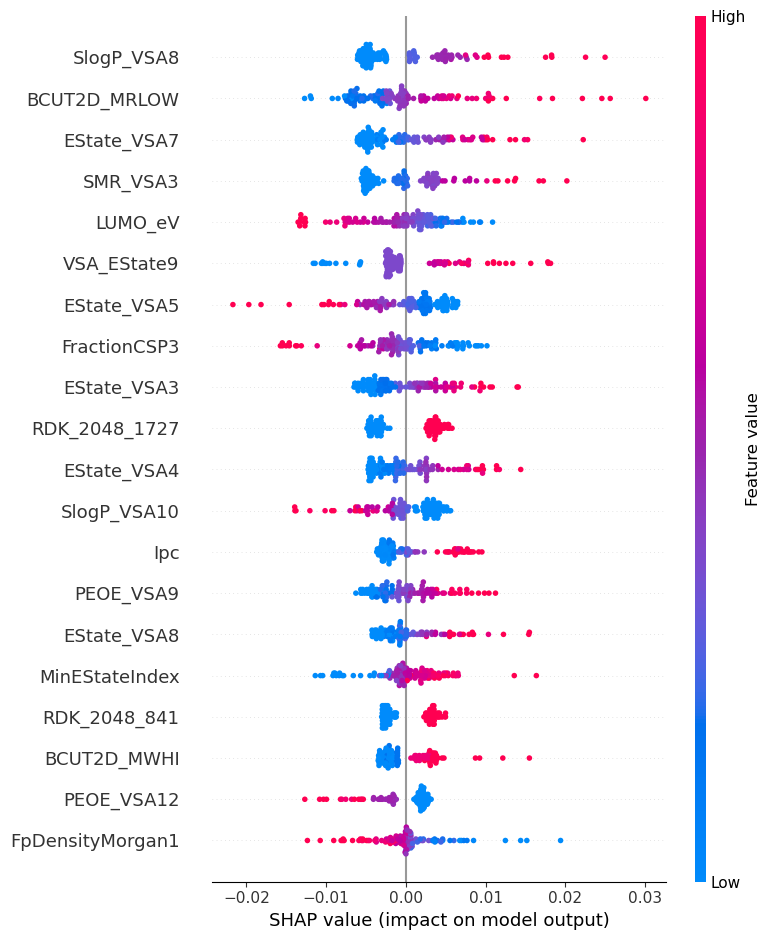

In [7]:
# SHAP features
# Prediction function for SHAP
f = lambda X: base_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train)
shap_result = explainer(X_train, max_evals=2 * X_train.shape[1] + 20)

# Each row has values for features
shap_values = shap_result.values

# Mean absolute SHAP value per feature (importance)
shap_importance = np.abs(shap_values).mean(axis=0)
shap_features = pd.Series(shap_importance, index=X_train.columns).sort_values(
    ascending=False
)

# K-Best - Anova features
kbest = SelectKBest(score_func=f_classif, k="all")
kbest.fit(X_train, y_train)
kbest_scores = pd.Series(kbest.scores_, index=X_train.columns).fillna(0.0)
kbest_features = kbest_scores.sort_values(ascending=False)

# Lasso features
lasso = LogisticRegression(penalty="l1", C=1.0, solver="liblinear", max_iter=5000)
lasso.fit(X_train, y_train)

lasso_importance = pd.Series(np.abs(lasso.coef_).ravel(), index=X_train.columns)
lasso_features = lasso_importance.sort_values(ascending=False)

# Plot
shap.summary_plot(shap_values, X_train)

## SHAP Features


In [8]:
shap_features.head(20)

SlogP_VSA8          0.005309
BCUT2D_MRLOW        0.005131
EState_VSA7         0.004657
SMR_VSA3            0.004249
LUMO_eV             0.004140
VSA_EState9         0.004105
EState_VSA5         0.004023
FractionCSP3        0.003999
EState_VSA3         0.003966
RDK_2048_1727       0.003756
EState_VSA4         0.003546
SlogP_VSA10         0.003353
Ipc                 0.003167
PEOE_VSA9           0.003018
EState_VSA8         0.002897
MinEStateIndex      0.002864
RDK_2048_841        0.002796
BCUT2D_MWHI         0.002714
PEOE_VSA12          0.002676
FpDensityMorgan1    0.002667
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.682332  0.674876    0.720056
1     10     0.650841  0.662591    0.767689
2     15     0.720553  0.734588    0.778908
3     20     0.704808  0.720588    0.796737
4     25     0.712861  0.737827    0.801148

Best number of features by CV F1: 90
Top_N          90.000000
CV_Accuracy     0.774880
CV_F1           0.792046
CV_ROC_AUC      0.869076
Name: 17, dtype: float64


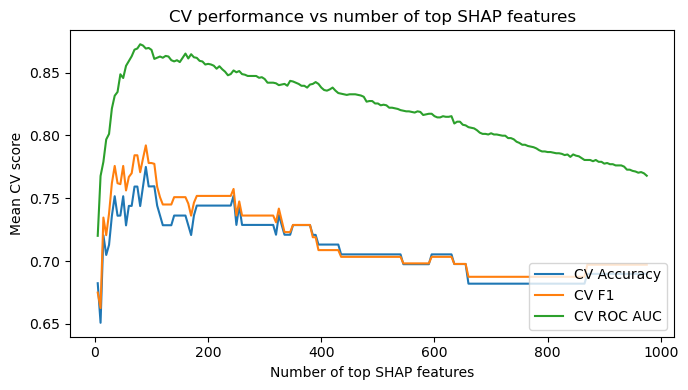

In [9]:
results = []

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(shap_features) + 1, 5):
    top_feats = shap_features.head(n).index

    model = SVC(
        kernel="rbf",
        probability=True,
        random_state=42,
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
        n_jobs=-1,
        return_train_score=False,
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_shap = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top SHAP features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top SHAP features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## KBEST Features


In [10]:
kbest_features.head(20)

RDK_2048_1727    61.730479
RDK_2048_841     37.249219
RDK_2048_34      30.766692
RDK_2048_109     30.568538
RDK_2048_449     30.043949
RDK_2048_429     29.921829
RDK_2048_1375    29.579104
RDK_2048_453     29.012759
RDK_2048_1189    26.537915
RDK_2048_865     26.473703
RDK_2048_1387    26.473703
RDK_2048_354     25.784260
RDK_2048_84      24.605035
RDK_2048_233     24.605035
RDK_2048_808     24.507216
RDK_2048_1993    24.507216
RDK_2048_1184    24.505004
RDK_2048_534     23.567010
RDK_2048_1443    23.567010
RDK_2048_195     23.449508
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.759495  0.760231    0.791352
1     10     0.712981  0.726190    0.803957
2     15     0.759375  0.771429    0.825392
3     20     0.759375  0.771429    0.843831
4     25     0.759255  0.777962    0.851239

Best number of features by CV F1: 30
Top_N          30.000000
CV_Accuracy     0.774880
CV_F1           0.789373
CV_ROC_AUC      0.841723
Name: 5, dtype: float64


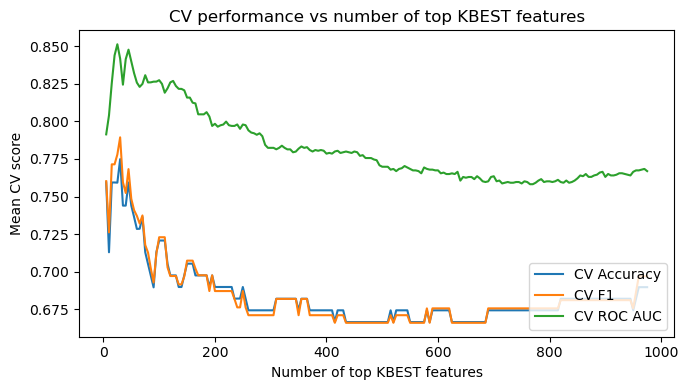

In [11]:
results = []

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(kbest_features) + 1, 5):
    top_feats = kbest_features.head(n).index

    model = SVC(
        kernel="rbf",
        probability=True,
        random_state=42,
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
        n_jobs=-1,
        return_train_score=False,
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_kbest = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top KBEST features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top KBEST features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## LASSO Features


In [12]:
lasso_features.head(20)

RDK_2048_841          1.472224
AtomPair_2048_760     0.984153
AtomPair_2048_888     0.940040
RDK_2048_1441         0.864187
RDK_2048_460          0.800045
VSA_EState9           0.797103
RDK_2048_1421         0.768149
RDK_2048_52           0.757895
RDK_2048_1827         0.738363
RDK_2048_1221         0.704616
RDK_2048_84           0.650858
Ipc                   0.632243
SMR_VSA3              0.582389
RDK_2048_1727         0.535539
RDK_2048_1923         0.525478
RDK_2048_1038         0.522640
RDK_2048_1191         0.512634
RDK_2048_228          0.507993
RDK_2048_766          0.470900
AtomPair_2048_1018    0.467856
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.721034  0.750614    0.809503
1     10     0.798077  0.815359    0.872080
2     15     0.844712  0.854622    0.919454
3     20     0.829087  0.847222    0.923585
4     25     0.844351  0.855072    0.935798

Best number of features by CV F1: 25
Top_N          25.000000
CV_Accuracy     0.844351
CV_F1           0.855072
CV_ROC_AUC      0.935798
Name: 4, dtype: float64


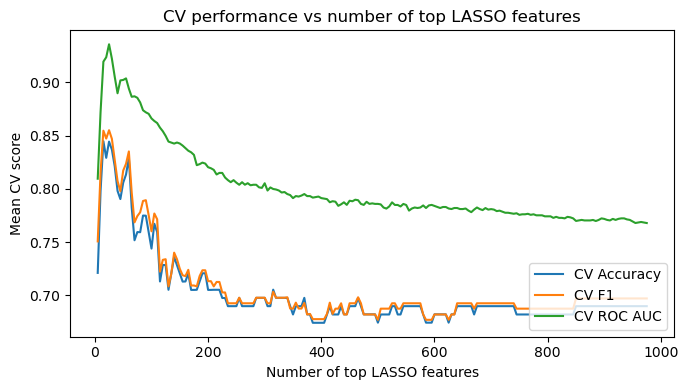

In [13]:
results = []

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(lasso_features) + 1, 5):
    top_feats = lasso_features.head(n).index

    model = SVC(
        kernel="rbf",
        probability=True,
        random_state=42,
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
        n_jobs=-1,
        return_train_score=False,
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_lasso = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top LASSO features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top LASSO features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Model SHAP Features


In [14]:
top_feats = shap_features.head(best_n_shap).index.tolist()

# Train final model
final_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (SHAP) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (SHAP) on test:
Accuracy:  0.6970
Precision: 0.7857
Recall:    0.6111
F1 score:  0.6875
ROC AUC:   0.7296


## Model KBEST Features


In [15]:
top_feats = kbest_features.head(best_n_kbest).index.tolist()

# Train final model
final_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (KBEST) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (KBEST) on test:
Accuracy:  0.6364
Precision: 0.6875
Recall:    0.6111
F1 score:  0.6471
ROC AUC:   0.7778


## Model LASSO Features


In [16]:
top_feats = lasso_features.head(best_n_lasso).index.tolist()

# Train final model
final_model = SVC(
    kernel="rbf",
    probability=True,
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (LASSO) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (LASSO) on test:
Accuracy:  0.6364
Precision: 0.7143
Recall:    0.5556
F1 score:  0.6250
ROC AUC:   0.6963


## Model SHAP Features Tuning


In [17]:
top_feats = shap_features.head(best_n_shap).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)


# Optuna
def objective(trial):
    # ---- Optuna param space for SVM ----
    params = {
        "kernel": trial.suggest_categorical(
            "kernel", ["rbf", "linear", "poly", "sigmoid"]
        ),
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True),
        "max_iter": trial.suggest_categorical("max_iter", [-1, 1000, 2000]),
        "probability": True,  # needed if you evaluate with predicted probabilities (e.g., ROC AUC)
        "random_state": 42,
        "cache_size": 1000.0,
    }

    # gamma choice: allow "scale"/"auto" or a numeric value
    gamma_mode = trial.suggest_categorical("gamma_mode", ["scale", "auto", "float"])
    if gamma_mode == "float":
        params["gamma"] = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
    else:
        params["gamma"] = gamma_mode

    # conditionals for poly/sigmoid
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    elif params["kernel"] == "sigmoid":
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    # for "rbf" and "linear" degree/coef0 are ignored, so we omit them

    # ---- Model ----
    model = SVC(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1,
    )

    return scores.mean()


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

best_params = study.best_params.copy()

# Map gamma_mode -> gamma
gamma_mode = best_params.pop("gamma_mode", "scale")
if gamma_mode != "float":
    # 'scale' or 'auto'
    best_params["gamma"] = gamma_mode
# else: when gamma_mode == 'float', Optuna already stored a numeric 'gamma' in best_params

best_params.update(
    {
        "probability": True,  # needed for predict_proba below
        "random_state": 42,
        "cache_size": 1000.0,
    }
)

# Final model
final_model = SVC(**best_params)
final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (SHAP):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 1. Best value: 0.865842:   2%|▏         | 3/200 [00:00<00:06, 28.61it/s]/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
Best trial: 25. Best value: 0.897894:  38%|███▊      | 77/200 [00:02<00:03, 33.47it/s]/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
Best trial: 25. Best value: 0.897894:  48%|████▊     | 97/200 [00:02<00:03, 32.74it/s]/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
Best trial: 25.


Best trial:
  Value: 0.897893772893773
  Params:
    kernel: poly
    C: 5.095390646825988
    class_weight: balanced
    shrinking: False
    tol: 3.0318879791522427e-05
    max_iter: 2000
    gamma_mode: scale
    degree: 3
    coef0: 0.3840168168121365

Final Optuna model (SHAP):
Accuracy:  0.6364
Precision: 0.7500
Recall:    0.5000
F1 score:  0.6000
ROC AUC:   0.7519


## Model KBEST Features Tuning


In [18]:
top_feats = kbest_features.head(best_n_kbest).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)


# Optuna
def objective(trial):
    # Hyperparameter search space
    # ---- Optuna param space for SVM ----
    params = {
        "kernel": trial.suggest_categorical(
            "kernel", ["rbf", "linear", "poly", "sigmoid"]
        ),
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True),
        "max_iter": trial.suggest_categorical("max_iter", [-1, 1000, 2000]),
        "probability": True,  # needed if you evaluate with predicted probabilities (e.g., ROC AUC)
        "random_state": 42,
        "cache_size": 1000.0,
    }

    # gamma choice: allow "scale"/"auto" or a numeric value
    gamma_mode = trial.suggest_categorical("gamma_mode", ["scale", "auto", "float"])
    if gamma_mode == "float":
        params["gamma"] = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
    else:
        params["gamma"] = gamma_mode

    # conditionals for poly/sigmoid
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    elif params["kernel"] == "sigmoid":
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    # for "rbf" and "linear" degree/coef0 are ignored, so we omit them

    # ---- Model ----
    model = SVC(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        scoring="f1",
        # scoring="roc_auc",
        n_jobs=-1,
    )

    return scores.mean()


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")


best_params = study.best_params.copy()

# Map gamma_mode -> gamma
gamma_mode = best_params.pop("gamma_mode", "scale")
if gamma_mode != "float":
    # 'scale' or 'auto'
    best_params["gamma"] = gamma_mode
# else: when gamma_mode == 'float', Optuna already stored a numeric 'gamma' in best_params

best_params.update(
    {
        "probability": True,  # needed for predict_proba below
        "random_state": 42,
        "cache_size": 1000.0,
    }
)

# Final model
final_model = SVC(**best_params)
final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (KBEST):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 105. Best value: 0.824396: 100%|██████████| 200/200 [00:05<00:00, 34.62it/s]


Best trial:
  Value: 0.824396301593187
  Params:
    kernel: sigmoid
    C: 1.7593422983607065
    class_weight: None
    shrinking: False
    tol: 0.0010803671337955563
    max_iter: -1
    gamma_mode: auto
    coef0: 0.8940450427873428

Final Optuna model (KBEST):
Accuracy:  0.6364
Precision: 0.6875
Recall:    0.6111
F1 score:  0.6471
ROC AUC:   0.7370


## Model LASSO Features Tuning


In [19]:
top_feats = lasso_features.head(best_n_lasso).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)


# Optuna
def objective(trial):
    # ---- Optuna param space for SVM ----
    params = {
        "kernel": trial.suggest_categorical(
            "kernel", ["rbf", "linear", "poly", "sigmoid"]
        ),
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True),
        "max_iter": trial.suggest_categorical("max_iter", [-1, 1000, 2000]),
        "probability": True,  # needed if you evaluate with predicted probabilities (e.g., ROC AUC)
        "random_state": 42,
        "cache_size": 1000.0,
    }

    # gamma choice: allow "scale"/"auto" or a numeric value
    gamma_mode = trial.suggest_categorical("gamma_mode", ["scale", "auto", "float"])
    if gamma_mode == "float":
        params["gamma"] = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
    else:
        params["gamma"] = gamma_mode

    # conditionals for poly/sigmoid
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    elif params["kernel"] == "sigmoid":
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    # for "rbf" and "linear" degree/coef0 are ignored, so we omit them

    # ---- Model ----
    model = SVC(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1,
    )

    return scores.mean()


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")


best_params = study.best_params.copy()

# Map gamma_mode -> gamma
gamma_mode = best_params.pop("gamma_mode", "scale")
if gamma_mode != "float":
    # 'scale' or 'auto'
    best_params["gamma"] = gamma_mode
# else: when gamma_mode == 'float', Optuna already stored a numeric 'gamma' in best_params

best_params.update(
    {
        "probability": True,  # needed for predict_proba below
        "random_state": 42,
        "cache_size": 1000.0,
    }
)

# Final model
final_model = SVC(**best_params)
final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (LASSO):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

  0%|          | 0/200 [00:00<?, ?it/s]/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warn


Best trial:
  Value: 0.9856227106227106
  Params:
    kernel: linear
    C: 1.1136774226255703
    class_weight: None
    shrinking: True
    tol: 0.00024018615140342035
    max_iter: 1000
    gamma_mode: auto

Final Optuna model (LASSO):
Accuracy:  0.6061
Precision: 0.6923
Recall:    0.5000
F1 score:  0.5806
ROC AUC:   0.6963


## Model SHAP Features Tuning


In [20]:
top_feats = shap_features.head(best_n_shap).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)


# Optuna
def objective(trial):
    # ---- Optuna param space for SVM ----
    params = {
        "kernel": trial.suggest_categorical(
            "kernel", ["rbf", "linear", "poly", "sigmoid"]
        ),
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True),
        "max_iter": trial.suggest_categorical("max_iter", [-1, 1000, 2000]),
        "probability": True,  # needed if you evaluate with predicted probabilities (e.g., ROC AUC)
        "random_state": 42,
        "cache_size": 1000.0,
    }

    # gamma choice: allow "scale"/"auto" or a numeric value
    gamma_mode = trial.suggest_categorical("gamma_mode", ["scale", "auto", "float"])
    if gamma_mode == "float":
        params["gamma"] = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
    else:
        params["gamma"] = gamma_mode

    # conditionals for poly/sigmoid
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    elif params["kernel"] == "sigmoid":
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    # for "rbf" and "linear" degree/coef0 are ignored, so we omit them

    # ---- Model ----
    model = SVC(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1,
    )

    return scores.mean()


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

best_params = study.best_params.copy()

# Map gamma_mode -> gamma
gamma_mode = best_params.pop("gamma_mode", "scale")
if gamma_mode != "float":
    # 'scale' or 'auto'
    best_params["gamma"] = gamma_mode
# else: when gamma_mode == 'float', Optuna already stored a numeric 'gamma' in best_params

best_params.update(
    {
        "probability": True,  # needed for predict_proba below
        "random_state": 42,
        "cache_size": 1000.0,
    }
)

# Final model
final_model = SVC(**best_params)
final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (SHAP):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 19. Best value: 0.893132:  10%|▉         | 19/200 [00:00<00:05, 36.01it/s]/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
Best trial: 22. Best value: 0.896703:  14%|█▎        | 27/200 [00:00<00:04, 34.91it/s]/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: Conver


Best trial:
  Value: 0.897893772893773
  Params:
    kernel: poly
    C: 105.81667361282629
    class_weight: balanced
    shrinking: False
    tol: 0.004346706562355248
    max_iter: 1000
    gamma_mode: auto
    degree: 3
    coef0: 0.186595851005465

Final Optuna model (SHAP):
Accuracy:  0.6364
Precision: 0.7500
Recall:    0.5000
F1 score:  0.6000
ROC AUC:   0.7519


## Model KBEST Features Tuning


In [21]:
top_feats = kbest_features.head(best_n_kbest).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)


# Optuna
def objective(trial):
    # Hyperparameter search space
    # ---- Optuna param space for SVM ----
    params = {
        "kernel": trial.suggest_categorical(
            "kernel", ["rbf", "linear", "poly", "sigmoid"]
        ),
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True),
        "max_iter": trial.suggest_categorical("max_iter", [-1, 1000, 2000]),
        "probability": True,  # needed if you evaluate with predicted probabilities (e.g., ROC AUC)
        "random_state": 42,
        "cache_size": 1000.0,
    }

    # gamma choice: allow "scale"/"auto" or a numeric value
    gamma_mode = trial.suggest_categorical("gamma_mode", ["scale", "auto", "float"])
    if gamma_mode == "float":
        params["gamma"] = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
    else:
        params["gamma"] = gamma_mode

    # conditionals for poly/sigmoid
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    elif params["kernel"] == "sigmoid":
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    # for "rbf" and "linear" degree/coef0 are ignored, so we omit them

    # ---- Model ----
    model = SVC(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        scoring="f1",
        # scoring="roc_auc",
        n_jobs=-1,
    )

    return scores.mean()


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")


best_params = study.best_params.copy()

# Map gamma_mode -> gamma
gamma_mode = best_params.pop("gamma_mode", "scale")
if gamma_mode != "float":
    # 'scale' or 'auto'
    best_params["gamma"] = gamma_mode
# else: when gamma_mode == 'float', Optuna already stored a numeric 'gamma' in best_params

best_params.update(
    {
        "probability": True,  # needed for predict_proba below
        "random_state": 42,
        "cache_size": 1000.0,
    }
)

# Final model
final_model = SVC(**best_params)
final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (KBEST):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 0. Best value: 0.796382:   4%|▍         | 9/200 [00:00<00:04, 39.59it/s]/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your dat


Best trial:
  Value: 0.8170844736361978
  Params:
    kernel: rbf
    C: 0.286263788119496
    class_weight: balanced
    shrinking: True
    tol: 0.0002561732161118201
    max_iter: 2000
    gamma_mode: float
    gamma: 0.149476532800459

Final Optuna model (KBEST):
Accuracy:  0.6061
Precision: 0.6667
Recall:    0.5556
F1 score:  0.6061
ROC AUC:   0.7593


# Model LASSO Features Tuning


In [22]:
top_feats = lasso_features.head(best_n_lasso).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)


# Optuna
def objective(trial):
    # ---- Optuna param space for SVM ----
    params = {
        "kernel": trial.suggest_categorical(
            "kernel", ["rbf", "linear", "poly", "sigmoid"]
        ),
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "tol": trial.suggest_float("tol", 1e-5, 1e-2, log=True),
        "max_iter": trial.suggest_categorical("max_iter", [-1, 1000, 2000]),
        "probability": True,  # needed if you evaluate with predicted probabilities (e.g., ROC AUC)
        "random_state": 42,
        "cache_size": 1000.0,
    }

    # gamma choice: allow "scale"/"auto" or a numeric value
    gamma_mode = trial.suggest_categorical("gamma_mode", ["scale", "auto", "float"])
    if gamma_mode == "float":
        params["gamma"] = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
    else:
        params["gamma"] = gamma_mode

    # conditionals for poly/sigmoid
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    elif params["kernel"] == "sigmoid":
        params["coef0"] = trial.suggest_float("coef0", 0.0, 1.0)
    # for "rbf" and "linear" degree/coef0 are ignored, so we omit them

    # ---- Model ----
    model = SVC(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1,
    )

    return scores.mean()


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")


best_params = study.best_params.copy()

# Map gamma_mode -> gamma
gamma_mode = best_params.pop("gamma_mode", "scale")
if gamma_mode != "float":
    # 'scale' or 'auto'
    best_params["gamma"] = gamma_mode
# else: when gamma_mode == 'float', Optuna already stored a numeric 'gamma' in best_params

best_params.update(
    {
        "probability": True,  # needed for predict_proba below
        "random_state": 42,
        "cache_size": 1000.0,
    }
)

# Final model
final_model = SVC(**best_params)
final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (LASSO):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 1. Best value: 0.961996:   5%|▌         | 10/200 [00:00<00:04, 43.62it/s]/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your da


Best trial:
  Value: 0.9856227106227106
  Params:
    kernel: linear
    C: 1.2893572502636284
    class_weight: None
    shrinking: True
    tol: 1.552190061591114e-05
    max_iter: 1000
    gamma_mode: float
    gamma: 0.0008062778014885163

Final Optuna model (LASSO):
Accuracy:  0.6061
Precision: 0.6923
Recall:    0.5000
F1 score:  0.5806
ROC AUC:   0.6963



/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


## Model SHAP Features Tuning (Randomized Search CV)


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs


=== Testing top 5 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.0028660676169482502), 'degree': 3, 'coef0': np.float64(0.8), 'class_weight': None, 'C': np.float64(14.48118227674533)}
Accuracy: 0.606 | ROC-AUC: 0.641

=== Testing top 6 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.0015998587196060573), 'shrinking': False, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(2.9673024081888726), 'coef0': np.float64(0.35000000000000003), 'class_weight': None, 'C': np.float64(0.05607169938205458)}
Accuracy: 0.606 | ROC-AUC: 0.589

=== Testing top 7 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.00022229964825261955), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.0028660676169482502), 'degree': 3, 'coef0': np.float64(0.8), 'class_weight': None, 'C': np.float64(14.48118227674533)}
Accuracy: 0.606 | ROC-AUC: 0.585

=== Testing top 8 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.0024094035602395267), 'degree': 3, 'coef0': np.float64(0.75), 'class_weight': None, 'C': np.float64(11.758495540521558)}
Accuracy: 0.606 | ROC-AUC: 0.570

=== Testing top 9 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.0015998587196060573), 'shrinking': False, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(2.9673024081888726), 'coef0': np.float64(0.35000000000000003), 'class_weight': None, 'C': np.float64(0.05607169938205458)}
Accuracy: 0.485 | ROC-AUC: 0.485

=== Testing top 10 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.0024094035602395267), 'degree': 3, 'coef0': np.float64(0.75), 'class_weight': None, 'C': np.float64(11.758495540521558)}
Accuracy: 0.515 | ROC-AUC: 0.596

=== Testing top 11 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.0024420530945486497), 'shrinking': True, 'max_iter': 1000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0014314589375234786), 'coef0': np.float64(0.8500000000000001), 'class_weight': None, 'C': np.float64(28.99422853882875)}
Accuracy: 0.576 | ROC-AUC: 0.611

=== Testing top 12 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.455 | ROC-AUC: 0.322

=== Testing top 13 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.0024420530945486497), 'shrinking': True, 'max_iter': 1000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0014314589375234786), 'coef0': np.float64(0.8500000000000001), 'class_weight': None, 'C': np.float64(28.99422853882875)}
Accuracy: 0.545 | ROC-AUC: 0.633

=== Testing top 14 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.0024094035602395267), 'degree': 3, 'coef0': np.float64(0.75), 'class_weight': None, 'C': np.float64(11.758495540521558)}
Accuracy: 0.515 | ROC-AUC: 0.622

=== Testing top 15 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.006080224261649427), 'degree': 5, 'coef0': np.float64(0.15000000000000002), 'class_weight': None, 'C': np.float64(0.03001835813575589)}
Accuracy: 0.545 | ROC-AUC: 0.693

=== Testing top 16 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.006080224261649427), 'degree': 5, 'coef0': np.float64(0.15000000000000002), 'class_weight': None, 'C': np.float64(0.03001835813575589)}
Accuracy: 0.545 | ROC-AUC: 0.663

=== Testing top 17 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.545 | ROC-AUC: 0.637

=== Testing top 18 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.0024420530945486497), 'shrinking': True, 'max_iter': 1000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0014314589375234786), 'coef0': np.float64(0.8500000000000001), 'class_weight': None, 'C': np.float64(28.99422853882875)}
Accuracy: 0.545 | ROC-AUC: 0.670

=== Testing top 19 features ===
Best parameters: {'tol': np.float64(1.5264179671752335e-05), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.1096985797892384), 'degree': 3, 'coef0': np.float64(0.7000000000000001), 'class_weight': None, 'C': np.float64(0.001320088400831418)}
Accuracy: 0.545 | ROC-AUC: 0.674

=== Testing top 20 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.606 | ROC-AUC: 0.681

=== Testing top 21 features ===
Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.636 | ROC-AUC: 0.685

=== Testing top 22 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.622

=== Testing top 23 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.626

=== Testing top 24 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.644

=== Testing top 25 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.641

=== Testing top 26 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.644

=== Testing top 27 features ===
Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.637

=== Testing top 28 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.641

=== Testing top 29 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.641

=== Testing top 30 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.659

=== Testing top 31 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.652

=== Testing top 32 features ===
Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.652

=== Testing top 33 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.606 | ROC-AUC: 0.737

=== Testing top 34 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.636 | ROC-AUC: 0.744

=== Testing top 35 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.685

=== Testing top 36 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.004941713361323833), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.020490746898158482), 'degree': 5, 'coef0': np.float64(0.6000000000000001), 'class_weight': 'balanced', 'C': np.float64(0.7316807143427192)}
Accuracy: 0.606 | ROC-AUC: 0.770

=== Testing top 37 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.636 | ROC-AUC: 0.737

=== Testing top 38 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.636 | ROC-AUC: 0.730

=== Testing top 39 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.606 | ROC-AUC: 0.741

=== Testing top 40 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.576 | ROC-AUC: 0.730

=== Testing top 41 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.606 | ROC-AUC: 0.737

=== Testing top 42 features ===
Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.606 | ROC-AUC: 0.744

=== Testing top 43 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.606 | ROC-AUC: 0.759

=== Testing top 44 features ===
Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.636 | ROC-AUC: 0.759

=== Testing top 45 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.606 | ROC-AUC: 0.756

=== Testing top 46 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.004941713361323833), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.020490746898158482), 'degree': 5, 'coef0': np.float64(0.6000000000000001), 'class_weight': 'balanced', 'C': np.float64(0.7316807143427192)}
Accuracy: 0.636 | ROC-AUC: 0.759

=== Testing top 47 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.004941713361323833), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.020490746898158482), 'degree': 5, 'coef0': np.float64(0.6000000000000001), 'class_weight': 'balanced', 'C': np.float64(0.7316807143427192)}
Accuracy: 0.636 | ROC-AUC: 0.759

=== Testing top 48 features ===
Best parameters: {'tol': np.float64(0.004941713361323833), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.020490746898158482), 'degree': 5, 'coef0': np.float64(0.6000000000000001), 'class_weight': 'balanced', 'C': np.float64(0.7316807143427192)}
Accuracy: 0.636 | ROC-AUC: 0.763

=== Testing top 49 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.004941713361323833), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.020490746898158482), 'degree': 5, 'coef0': np.float64(0.6000000000000001), 'class_weight': 'balanced', 'C': np.float64(0.7316807143427192)}
Accuracy: 0.636 | ROC-AUC: 0.767

=== Testing top 50 features ===
Best parameters: {'tol': np.float64(3.0888435964774785e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.010234114021054537), 'degree': 3, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(329.2971255097148)}
Accuracy: 0.636 | ROC-AUC: 0.648

=== Testing top 51 features ===
Best parameters: {'tol': np.float64(3.0888435964774785e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.010234114021054537), 'degree': 3, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(329.2971255097148)}
Accuracy: 0.636 | ROC-AUC: 0.652

=== Testing top

/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.606 | ROC-AUC: 0.767

=== Testing top 53 features ===
Best parameters: {'tol': np.float64(3.0888435964774785e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.010234114021054537), 'degree': 3, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(329.2971255097148)}
Accuracy: 0.636 | ROC-AUC: 0.648

=== Testing top 54 features ===
Best parameters: {'tol': np.float64(2.6826957952797274e-05), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.021711179456945052), 'degree': 2, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(0.9658832241158698)}
Accuracy: 0.636 | ROC-AUC: 0.741


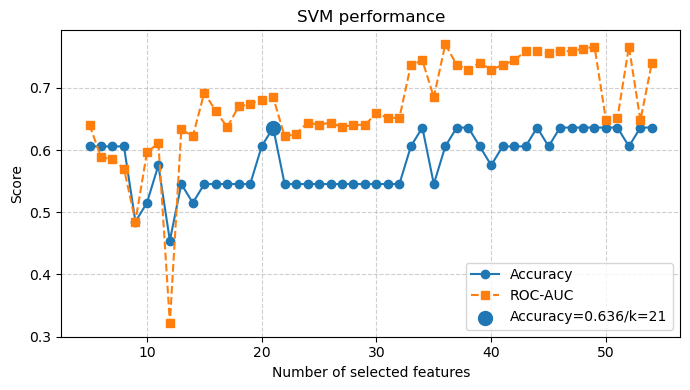


Accuracy = 0.636 | ROC-AUC = 0.685 | k = 21


In [23]:
ranking = shap_features

# Search spaces per kernel (lists => sampled uniformly)
search_spaces = [
    # linear
    {
        "kernel": ["linear"],
        "C": list(np.logspace(-3, 3, 200)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # rbf
    {
        "kernel": ["rbf"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # poly
    {
        "kernel": ["poly"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "degree": [2, 3, 4, 5],
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # sigmoid
    {
        "kernel": ["sigmoid"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
]

results = []
for k in range(5, 55):
    print(f"\n=== Testing top {k} features ===")
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    base = SVC(probability=True, random_state=42, cache_size=1000.0)

    search = RandomizedSearchCV(
        estimator=base,
        param_distributions=search_spaces,  # list of dicts => supports conditionals
        n_iter=80,
        scoring="roc_auc",  # align search with AUC
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0,
        error_score="raise",
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results, dtype=float)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, "o-", label="Accuracy")
plt.plot(feature_counts, auc_scores, "s--", label="ROC-AUC")
plt.scatter(
    best_k, best_acc, s=100, zorder=5, label=f"Accuracy={best_acc:.3f}/k={best_k}"
)
plt.title("SVM performance")
plt.xlabel("Number of selected features")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f} | ROC-AUC = {best_auc:.3f} | k = {best_k}")

## Model KBEST Features Tuning (Randomized Search CV)



=== Testing top 5 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.0010481131341546852), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.13826221737646563), 'coef0': np.float64(0.9), 'class_weight': 'balanced', 'C': np.float64(0.18251834943190423)}
Accuracy: 0.636 | ROC-AUC: 0.648

=== Testing top 6 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.0010481131341546852), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.13826221737646563), 'coef0': np.float64(0.9), 'class_weight': 'balanced', 'C': np.float64(0.18251834943190423)}
Accuracy: 0.667 | ROC-AUC: 0.691

=== Testing top 7 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.0010481131341546852), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.13826221737646563), 'coef0': np.float64(0.9), 'class_weight': 'balanced', 'C': np.float64(0.18251834943190423)}
Accuracy: 0.667 | ROC-AUC: 0.687

=== Testing top 8 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.0010481131341546852), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.13826221737646563), 'coef0': np.float64(0.9), 'class_weight': 'balanced', 'C': np.float64(0.18251834943190423)}
Accuracy: 0.727 | ROC-AUC: 0.696

=== Testing top 9 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.0004498432668969444), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.2072921779595372), 'degree': 5, 'coef0': np.float64(0.65), 'class_weight': 'balanced', 'C': np.float64(0.01135733358343105)}
Accuracy: 0.545 | ROC-AUC: 0.700

=== Testing top 10 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(2.6826957952797274e-05), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.021711179456945052), 'degree': 2, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(0.9658832241158698)}
Accuracy: 0.515 | ROC-AUC: 0.731

=== Testing top 11 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.0024420530945486497), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.17426333860096507), 'coef0': np.float64(0.65), 'class_weight': None, 'C': np.float64(0.12033778407775893)}
Accuracy: 0.727 | ROC-AUC: 0.735

=== Testing top 12 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0015998587196060573), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.001011637979766207), 'coef0': np.float64(0.05), 'class_weight': None, 'C': np.float64(0.006080224261649421)}
Accuracy: 0.545 | ROC-AUC: 0.724

=== Testing top 13 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0003906939937054617), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.00042475715525368984), 'degree': 2, 'coef0': np.float64(0.8500000000000001), 'class_weight': None, 'C': np.float64(0.00429700470432084)}
Accuracy: 0.545 | ROC-AUC: 0.720

=== Testing top 14 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.739

=== Testing top 15 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.576 | ROC-AUC: 0.724

=== Testing top 16 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.576 | ROC-AUC: 0.730

=== Testing top 17 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0003906939937054617), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.00042475715525368984), 'degree': 2, 'coef0': np.float64(0.8500000000000001), 'class_weight': None, 'C': np.float64(0.00429700470432084)}
Accuracy: 0.545 | ROC-AUC: 0.711

=== Testing top 18 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0003906939937054617), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.00042475715525368984), 'degree': 2, 'coef0': np.float64(0.8500000000000001), 'class_weight': None, 'C': np.float64(0.00429700470432084)}
Accuracy: 0.545 | ROC-AUC: 0.715

=== Testing top 19 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.0015998587196060573), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.001011637979766207), 'coef0': np.float64(0.05), 'class_weight': None, 'C': np.float64(0.006080224261649421)}
Accuracy: 0.545 | ROC-AUC: 0.707

=== Testing top 20 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(1.5264179671752335e-05), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.1096985797892384), 'degree': 3, 'coef0': np.float64(0.7000000000000001), 'class_weight': None, 'C': np.float64(0.001320088400831418)}
Accuracy: 0.545 | ROC-AUC: 0.722

=== Testing top 21 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.0004498432668969444), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.2072921779595372), 'degree': 5, 'coef0': np.float64(0.65), 'class_weight': 'balanced', 'C': np.float64(0.01135733358343105)}
Accuracy: 0.576 | ROC-AUC: 0.748

=== Testing top 22 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.0015998587196060573), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.001011637979766207), 'coef0': np.float64(0.05), 'class_weight': None, 'C': np.float64(0.006080224261649421)}
Accuracy: 0.545 | ROC-AUC: 0.741

=== Testing top 23 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.752

=== Testing top 24 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.756

=== Testing top 25 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(1.5702901247293775), 'degree': 4, 'coef0': np.float64(0.15000000000000002), 'class_weight': 'balanced', 'C': np.float64(0.001)}
Accuracy: 0.606 | ROC-AUC: 0.637

=== Testing top 26 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.744

=== Testing top 27 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.545 | ROC-AUC: 0.763

=== Testing top 28 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.576 | ROC-AUC: 0.763

=== Testing top 29 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.576 | ROC-AUC: 0.752

=== Testing top 30 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0012067926406393288), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.00860346441668451), 'degree': 5, 'coef0': np.float64(0.0), 'class_weight': 'balanced', 'C': np.float64(706.7181273927491)}
Accuracy: 0.545 | ROC-AUC: 0.759

=== Testing top 31 features ===
Best parameters: {'tol': np.float64(4.094915062380427e-05), 'shrinking': True, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.1552225357427048), 'degree': 4, 'coef0': np.float64(0.2), 'class_weight': None, 'C': np.float64(0.004605922041145103)}
Accuracy: 0.576 | ROC-AUC: 0.756

=== Testing top 32 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0004498432668969444), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.2072921779595372), 'degree': 5, 'coef0': np.float64(0.65), 'class_weight': 'balanced', 'C': np.float64(0.01135733358343105)}
Accuracy: 0.576 | ROC-AUC: 0.685

=== Testing top 33 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0004498432668969444), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.2072921779595372), 'degree': 5, 'coef0': np.float64(0.65), 'class_weight': 'balanced', 'C': np.float64(0.01135733358343105)}
Accuracy: 0.606 | ROC-AUC: 0.719

=== Testing top 34 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0004498432668969444), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.2072921779595372), 'degree': 5, 'coef0': np.float64(0.65), 'class_weight': 'balanced', 'C': np.float64(0.01135733358343105)}
Accuracy: 0.606 | ROC-AUC: 0.737

=== Testing top 35 features ===
Best parameters: {'tol': np.float64(0.0004498432668969444), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.2072921779595372), 'degree': 5, 'coef0': np.float64(0.65), 'class_weight': 'balanced', 'C': np.float64(0.01135733358343105)}
Accuracy: 0.606 | ROC-AUC: 0.730

=== Testing top 36 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0004498432668969444), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.2072921779595372), 'degree': 5, 'coef0': np.float64(0.65), 'class_weight': 'balanced', 'C': np.float64(0.01135733358343105)}
Accuracy: 0.606 | ROC-AUC: 0.741

=== Testing top 37 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0004498432668969444), 'shrinking': False, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.2072921779595372), 'degree': 5, 'coef0': np.float64(0.65), 'class_weight': 'balanced', 'C': np.float64(0.01135733358343105)}
Accuracy: 0.606 | ROC-AUC: 0.741

=== Testing top 38 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.16446761779946645), 'degree': 5, 'coef0': np.float64(0.55), 'class_weight': 'balanced', 'C': np.float64(0.014992684327860455)}
Accuracy: 0.576 | ROC-AUC: 0.730

=== Testing top 39 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.16446761779946645), 'degree': 5, 'coef0': np.float64(0.55), 'class_weight': 'balanced', 'C': np.float64(0.014992684327860455)}
Accuracy: 0.576 | ROC-AUC: 0.730

=== Testing top 40 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.16446761779946645), 'degree': 5, 'coef0': np.float64(0.55), 'class_weight': 'balanced', 'C': np.float64(0.014992684327860455)}
Accuracy: 0.606 | ROC-AUC: 0.722

=== Testing top 41 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.16446761779946645), 'degree': 5, 'coef0': np.float64(0.55), 'class_weight': 'balanced', 'C': np.float64(0.014992684327860455)}
Accuracy: 0.606 | ROC-AUC: 0.733

=== Testing top 42 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.16446761779946645), 'degree': 5, 'coef0': np.float64(0.55), 'class_weight': 'balanced', 'C': np.float64(0.014992684327860455)}
Accuracy: 0.606 | ROC-AUC: 0.733

=== Testing top 43 features ===
Best parameters: {'tol': np.float64(7.196856730011514e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.16446761779946645), 'degree': 5, 'coef0': np.float64(0.55), 'class_weight': 'balanced', 'C': np.float64(0.014992684327860455)}
Accuracy: 0.606 | ROC-AUC: 0.741

=== Testing top 44 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.781

=== Testing top 45 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.785

=== Testing top 46 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.785

=== Testing top 47 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.781

=== Testing top 48 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.778

=== Testing top 49 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(1.5264179671752335e-05), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.1096985797892384), 'degree': 3, 'coef0': np.float64(0.7000000000000001), 'class_weight': None, 'C': np.float64(0.001320088400831418)}
Accuracy: 0.606 | ROC-AUC: 0.778

=== Testing top 50 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.778

=== Testing top 51 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(1.5264179671752335e-05), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.1096985797892384), 'degree': 3, 'coef0': np.float64(0.7000000000000001), 'class_weight': None, 'C': np.float64(0.001320088400831418)}
Accuracy: 0.606 | ROC-AUC: 0.778

=== Testing top 52 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.774

=== Testing top 53 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00016768329368110083), 'shrinking': False, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.025826187606826773), 'degree': 2, 'coef0': np.float64(0.1), 'class_weight': None, 'C': np.float64(0.005672426068491977)}
Accuracy: 0.545 | ROC-AUC: 0.770

=== Testing top 54 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.5564803062231284e-05), 'shrinking': True, 'max_iter': 2000, 'kernel': 'poly', 'gamma': np.float64(0.009115888299750819), 'degree': 4, 'coef0': np.float64(0.0), 'class_weight': None, 'C': np.float64(0.7316807143427192)}
Accuracy: 0.545 | ROC-AUC: 0.767


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


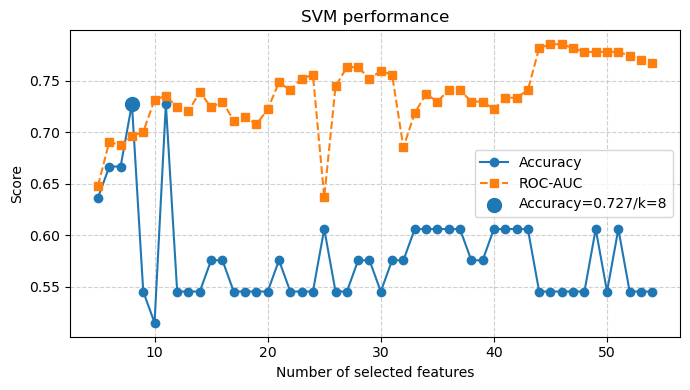


Accuracy = 0.727 | ROC-AUC = 0.696 | k = 8


In [25]:
ranking = kbest_features

# Search spaces per kernel (lists => sampled uniformly)
search_spaces = [
    # linear
    {
        "kernel": ["linear"],
        "C": list(np.logspace(-3, 3, 200)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # rbf
    {
        "kernel": ["rbf"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # poly
    {
        "kernel": ["poly"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "degree": [2, 3, 4, 5],
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # sigmoid
    {
        "kernel": ["sigmoid"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
]

results = []
for k in range(5, 55):
    print(f"\n=== Testing top {k} features ===")
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    base = SVC(probability=True, random_state=42, cache_size=1000.0)

    search = RandomizedSearchCV(
        estimator=base,
        param_distributions=search_spaces,  # list of dicts => supports conditionals
        n_iter=80,
        scoring="roc_auc",  # align search with AUC
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0,
        error_score="raise",
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results, dtype=float)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, "o-", label="Accuracy")
plt.plot(feature_counts, auc_scores, "s--", label="ROC-AUC")
plt.scatter(
    best_k, best_acc, s=100, zorder=5, label=f"Accuracy={best_acc:.3f}/k={best_k}"
)
plt.title("SVM performance")
plt.xlabel("Number of selected features")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f} | ROC-AUC = {best_auc:.3f} | k = {best_k}")

## Model LASSO Features Tuning (Randomized Search CV)


In [27]:
ranking = lasso_features

# Search spaces per kernel (lists => sampled uniformly)
search_spaces = [
    # linear
    {
        "kernel": ["linear"],
        "C": list(np.logspace(-3, 3, 200)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # rbf
    {
        "kernel": ["rbf"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # poly
    {
        "kernel": ["poly"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "degree": [2, 3, 4, 5],
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
    # sigmoid
    {
        "kernel": ["sigmoid"],
        "C": list(np.logspace(-3, 3, 200)),
        "gamma": (["scale", "auto"] + list(np.logspace(-4, 1, 200))),
        "coef0": list(np.linspace(0.0, 1.0, 21)),
        "class_weight": [None, "balanced"],
        "shrinking": [True, False],
        "tol": list(np.logspace(-5, -2, 50)),
        "max_iter": [-1, 1000, 2000],
    },
]

results = []
for k in range(5, 55):
    print(f"\n=== Testing top {k} features ===")
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    base = SVC(probability=True, random_state=42, cache_size=1000.0)

    search = RandomizedSearchCV(
        estimator=base,
        param_distributions=search_spaces,  # list of dicts => supports conditionals
        n_iter=80,
        scoring="roc_auc",  # align search with AUC
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0,
        error_score="raise",
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results, dtype=float)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, "o-", label="Accuracy")
plt.plot(feature_counts, auc_scores, "s--", label="ROC-AUC")
plt.scatter(
    best_k, best_acc, s=100, zorder=5, label=f"Accuracy={best_acc:.3f}/k={best_k}"
)
plt.title("SVM performance")
plt.xlabel("Number of selected features")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f} | ROC-AUC = {best_auc:.3f} | k = {best_k}")


=== Testing top 5 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.697 | ROC-AUC: 0.672

=== Testing top 6 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(3.0888435964774785e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.010234114021054537), 'degree': 3, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(329.2971255097148)}
Accuracy: 0.667 | ROC-AUC: 0.633

=== Testing top 7 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(3.0888435964774785e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.010234114021054537), 'degree': 3, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(329.2971255097148)}
Accuracy: 0.667 | ROC-AUC: 0.633

=== Testing top 8 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.0005963623316594642), 'shrinking': False, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.016257556664437952), 'coef0': np.float64(0.1), 'class_weight': 'balanced', 'C': np.float64(267.3841615839944)}
Accuracy: 0.606 | ROC-AUC: 0.633

=== Testing top 9 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.0005963623316594642), 'shrinking': False, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.016257556664437952), 'coef0': np.float64(0.1), 'class_weight': 'balanced', 'C': np.float64(267.3841615839944)}
Accuracy: 0.606 | ROC-AUC: 0.635

=== Testing top 10 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0024420530945486497), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.04605922041145108), 'degree': 4, 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(202.55019392306664)}
Accuracy: 0.576 | ROC-AUC: 0.593

=== Testing top 11 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.0024420530945486497), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.04605922041145108), 'degree': 4, 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(202.55019392306664)}
Accuracy: 0.576 | ROC-AUC: 0.567

=== Testing top 12 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(0.0024420530945486497), 'shrinking': True, 'max_iter': -1, 'kernel': 'poly', 'gamma': np.float64(0.17426333860096507), 'degree': 2, 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(58.05225516094895)}
Accuracy: 0.606 | ROC-AUC: 0.626

=== Testing top 13 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0024420530945486497), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.04605922041145108), 'degree': 4, 'coef0': np.float64(0.9500000000000001), 'class_weight': 'balanced', 'C': np.float64(202.55019392306664)}
Accuracy: 0.667 | ROC-AUC: 0.607

=== Testing top 14 features ===
Best parameters: {'tol': np.float64(0.0005963623316594642), 'shrinking': False, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.016257556664437952), 'coef0': np.float64(0.1), 'class_weight': 'balanced', 'C': np.float64(267.3841615839944)}
Accuracy: 0.576 | ROC-AUC: 0.615

=== Testing top 15 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs

Best parameters: {'tol': np.float64(3.0888435964774785e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.010234114021054537), 'degree': 3, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(329.2971255097148)}
Accuracy: 0.697 | ROC-AUC: 0.626

=== Testing top 16 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.0888435964774785e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.010234114021054537), 'degree': 3, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(329.2971255097148)}
Accuracy: 0.667 | ROC-AUC: 0.619

=== Testing top 17 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.0888435964774785e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.010234114021054537), 'degree': 3, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(329.2971255097148)}
Accuracy: 0.667 | ROC-AUC: 0.626

=== Testing top 18 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.0888435964774785e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.010234114021054537), 'degree': 3, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(329.2971255097148)}
Accuracy: 0.667 | ROC-AUC: 0.615

=== Testing top 19 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.0005963623316594642), 'shrinking': False, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.016257556664437952), 'coef0': np.float64(0.1), 'class_weight': 'balanced', 'C': np.float64(267.3841615839944)}
Accuracy: 0.545 | ROC-AUC: 0.622

=== Testing top 20 features ===
Best parameters: {'tol': np.float64(3.0888435964774785e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.010234114021054537), 'degree': 3, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(329.2971255097148)}
Accuracy: 0.576 | ROC-AUC: 0.611

=== Testing top 21 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.545 | ROC-AUC: 0.615

=== Testing top 22 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(3.0888435964774785e-05), 'shrinking': False, 'max_iter': 1000, 'kernel': 'poly', 'gamma': np.float64(0.010234114021054537), 'degree': 3, 'coef0': np.float64(0.6000000000000001), 'class_weight': None, 'C': np.float64(329.2971255097148)}
Accuracy: 0.606 | ROC-AUC: 0.619

=== Testing top 23 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters: {'tol': np.float64(0.00029470517025518097), 'shrinking': True, 'max_iter': 2000, 'kernel': 'sigmoid', 'gamma': np.float64(0.0009547716114208056), 'coef0': np.float64(0.2), 'class_weight': 'balanced', 'C': np.float64(870.3591361485165)}
Accuracy: 0.576 | ROC-AUC: 0.622

=== Testing top 24 features ===


/home/samuel/miniconda3/envs/toxipred/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


KeyboardInterrupt: 